In [1]:
!pip install numba --upgrade
!pip install numpy --upgrade
!pip install pandas --upgrade
!pip install --upgrade tbb
from data import Data
from signals import Signals
from central import Central
import backtest as bt
import pandas as pd
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

Requirement already up-to-date: numba in /usr/local/lib/python3.7/dist-packages (0.53.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.21.0)
Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.5)
Requirement already up-to-date: tbb in /usr/local/lib/python3.7/dist-packages (2021.2.0)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (40,15)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
robot = Central()

In [6]:
%%time
#robot.get_normal_data_csv('/content/drive/MyDrive/My_Project/Dados/EURUSD_20y.csv',drop=True,drop_list=['Unnamed: 0'], timeframe='D1', single_currency=True, pair='EURUSD')
#df = robot.get_normal_data()
#robot.get_normal_data_csv('/content/drive/MyDrive/My_Project/Dados/EURUSD_20y.csv',drop=True,drop_list=['Unnamed: 0'], timeframe='H4', single_currency=True, pair='EURUSD')
#df['H4'] = robot.get_normal_data()['H4']
robot.get_normal_data_csv('/content/drive/MyDrive/Programming/Dados/EURUSD_20y.csv',drop=True,drop_list=['Unnamed: 0'], timeframe='H1', single_currency=True, pair='EURUSD')
#df['H1'] = robot.get_normal_data()['H1']
df = robot.get_normal_data()
df

Dados Carregados com Sucesso.
CPU times: user 13.7 s, sys: 1.54 s, total: 15.3 s
Wall time: 15.9 s


In [7]:
#n = [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
new = pd.DataFrame()
times = 10
mean = pd.DataFrame()
mean['0'] = df['H1'].dropna().reset_index(drop=True)
for i in range(1, times):
    mean[f'{str(i)}'] = mean[str(i-1)].rolling(21).mean()
mean['test'] = mean.iloc[:, 1:].pct_change(axis=1).sum(axis=1)
d_list, u_list = [], []
down_mean, up_mean = 0, 0
for i, _ in enumerate(mean['test']):
    if i < 1:
        d_list.append(0)
        u_list.append(0)
        continue
    if mean['test'][i] > mean['test'][i-1]:
        up_mean += 1
        u_list.append(up_mean)
        d_list.append(down_mean)
        down_mean = 0
    elif mean['test'][i] < mean['test'][i-1]:
        down_mean += 1
        u_list.append(up_mean)
        d_list.append(down_mean)
        up_mean = 0
    else:
        u_list.append(up_mean)
        d_list.append(down_mean)
new['up'] = pd.Series(u_list)
new['down'] = pd.Series(d_list)

In [8]:
new.index = df.loc[df['time'].dt.minute == 0, 'H1'].index
new

,up,down
43,0,0
81,0,0
122,0,0
177,0,0
251,0,0
...,...,...
7747258,9,0
7747318,10,0
7747378,11,0
7747438,12,0


In [9]:
#new['H1Sell'] = df['H1'].dropna() > df['H1'].dropna().shift().rolling(10).max()
#new['H1Buy'] = df['H1'].dropna() < df['H1'].dropna().shift().rolling(10).min()
#new['H4Sell'] = df['H4'].dropna() > df['H4'].dropna().shift().rolling(10).max()
#new['H4Buy'] = df['H4'].dropna() < df['H4'].dropna().shift().rolling(10).min()
#new['D1Sell'] = df['D1'].dropna() > df['D1'].dropna().shift().rolling(10).max()
#new['D1Buy'] = df['D1'].dropna() < df['D1'].dropna().shift().rolling(10).min()
#new

In [10]:
#new.fillna(method='ffill', inplace=True)
#new.fillna(value=False, inplace=True)
#new

In [11]:
(new['up'] >= 10) & (new['up'].shift() < 10)

43         False
81         False
122        False
177        False
251        False
           ...  
7747258    False
7747318     True
7747378    False
7747438    False
7747498    False
Name: up, Length: 128551, dtype: bool

In [12]:
df.loc[df['time'].dt.minute == 0]

,time,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,tick_volume,spread,real_volume,H1
43,2000-01-03 01:00:00,1.01290,1.01300,1.01290,1.01300,2,50,0,1.01290
81,2000-01-03 02:00:00,1.01400,1.01400,1.01350,1.01350,6,50,0,1.01400
122,2000-01-03 03:00:00,1.01700,1.01750,1.01700,1.01750,4,50,0,1.01700
177,2000-01-03 04:00:00,1.01730,1.01760,1.01730,1.01740,4,50,0,1.01730
251,2000-01-03 06:00:00,1.01710,1.01710,1.01670,1.01670,5,50,0,1.01710
...,...,...,...,...,...,...,...,...,...
7747258,2021-05-21 19:00:00,1.21774,1.21774,1.21760,1.21763,48,0,0,1.21774
7747318,2021-05-21 20:00:00,1.21642,1.21648,1.21627,1.21633,59,0,0,1.21642
7747378,2021-05-21 21:00:00,1.21766,1.21770,1.21762,1.21762,35,0,0,1.21766
7747438,2021-05-21 22:00:00,1.21814,1.21814,1.21800,1.21801,24,0,0,1.21814


In [13]:
#df['Sell_Flag'] = new[['H1Sell', 'H4Sell', 'D1Sell']].sum(axis=1).replace([0, 1], False).replace([2, 3], True)
#df['Buy_Flag'] = new[['H1Buy', 'H4Buy', 'D1Buy']].sum(axis=1).replace([0, 1], False).replace([2, 3], True)
# df['Sell_Flag'] = df['H1'].dropna() > df['H1'].dropna().shift().rolling(15).max()
# df['Buy_Flag'] = df['H1'].dropna() < df['H1'].dropna().shift().rolling(15).min()
df.loc[df['H1'].index, 'Sell_Flag'] = (new['up'] >= 20) & (new['up'].shift() < 20)
df.loc[df['H1'].index, 'Buy_Flag'] = (new['down'] >= 20) & (new['down'].shift() < 20)

In [14]:
df

,time,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,tick_volume,spread,real_volume,H1,Sell_Flag,Buy_Flag
0,2000-01-03 00:01:00,1.00730,1.00750,1.00730,1.00730,5,50,0,NaN,NaN,NaN
1,2000-01-03 00:02:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN
2,2000-01-03 00:04:00,1.00780,1.00800,1.00770,1.00800,4,50,0,NaN,NaN,NaN
3,2000-01-03 00:12:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN
4,2000-01-03 00:13:00,1.00800,1.00800,1.00770,1.00770,4,50,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7747550,2021-05-21 23:52:00,1.21788,1.21794,1.21787,1.21794,12,0,0,NaN,NaN,NaN
7747551,2021-05-21 23:53:00,1.21794,1.21801,1.21794,1.21798,15,0,0,NaN,NaN,NaN
7747552,2021-05-21 23:54:00,1.21801,1.21808,1.21798,1.21808,17,0,0,NaN,NaN,NaN
7747553,2021-05-21 23:55:00,1.21808,1.21824,1.21807,1.21808,29,0,0,NaN,NaN,NaN


In [15]:
df['Sell_Flag'].sum(), df['Buy_Flag'].sum()

(1256, 1309)

In [16]:
robot.set_normal_data(df)
robot.get_normal_data()

,time,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,tick_volume,spread,real_volume,H1,Sell_Flag,Buy_Flag
0,2000-01-03 00:01:00,1.00730,1.00750,1.00730,1.00730,5,50,0,NaN,NaN,NaN
1,2000-01-03 00:02:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN
2,2000-01-03 00:04:00,1.00780,1.00800,1.00770,1.00800,4,50,0,NaN,NaN,NaN
3,2000-01-03 00:12:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN
4,2000-01-03 00:13:00,1.00800,1.00800,1.00770,1.00770,4,50,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7747550,2021-05-21 23:52:00,1.21788,1.21794,1.21787,1.21794,12,0,0,NaN,NaN,NaN
7747551,2021-05-21 23:53:00,1.21794,1.21801,1.21794,1.21798,15,0,0,NaN,NaN,NaN
7747552,2021-05-21 23:54:00,1.21801,1.21808,1.21798,1.21808,17,0,0,NaN,NaN,NaN
7747553,2021-05-21 23:55:00,1.21808,1.21824,1.21807,1.21808,29,0,0,NaN,NaN,NaN


In [ ]:
robot.tpsl_calculation_otimization_single(14)
robot.get_normal_data()

,time,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,tick_volume,spread,real_volume,H1,Sell_Flag,Buy_Flag,TPSL
0,2000-01-03 00:01:00,1.00730,1.00750,1.00730,1.00730,5,50,0,NaN,NaN,NaN,0.000351
1,2000-01-03 00:02:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN,0.000351
2,2000-01-03 00:04:00,1.00780,1.00800,1.00770,1.00800,4,50,0,NaN,NaN,NaN,0.000351
3,2000-01-03 00:12:00,1.00790,1.00790,1.00790,1.00790,1,50,0,NaN,NaN,NaN,0.000351
4,2000-01-03 00:13:00,1.00800,1.00800,1.00770,1.00770,4,50,0,NaN,NaN,NaN,0.000351
...,...,...,...,...,...,...,...,...,...,...,...,...
7747550,2021-05-21 23:52:00,1.21788,1.21794,1.21787,1.21794,12,0,0,NaN,NaN,NaN,0.000117
7747551,2021-05-21 23:53:00,1.21794,1.21801,1.21794,1.21798,15,0,0,NaN,NaN,NaN,0.000119
7747552,2021-05-21 23:54:00,1.21801,1.21808,1.21798,1.21808,17,0,0,NaN,NaN,NaN,0.000121
7747553,2021-05-21 23:55:00,1.21808,1.21824,1.21807,1.21808,29,0,0,NaN,NaN,NaN,0.000117


In [ ]:
robot.get_normal_data().loc[:, ['Sell_Flag', 'Buy_Flag']] = robot.get_normal_data().loc[:, ['Sell_Flag', 'Buy_Flag']].fillna(False)

In [ ]:
robot.get_normal_data().loc[:, ['H1']].fillna(method='ffill')

,H1
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
7747550,1.21857
7747551,1.21857
7747552,1.21857
7747553,1.21857


In [ ]:
robot.get_normal_data().loc[:, ['H1']] = robot.get_normal_data().loc[:, ['H1']].fillna(method='ffill')
robot.get_normal_data().loc[:, ['H1']] = robot.get_normal_data().loc[:, ['H1']].fillna(method='ffill').fillna(method='backfill')

In [ ]:
robot.get_normal_data().loc[:, ['EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'EURUSD_Close', 'H1', 'TPSL', 'Sell_Flag', 'Buy_Flag']]

,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,H1,TPSL,Sell_Flag,Buy_Flag
0,1.00730,1.00750,1.00730,1.00730,1.01290,0.000351,False,False
1,1.00790,1.00790,1.00790,1.00790,1.01290,0.000351,False,False
2,1.00780,1.00800,1.00770,1.00800,1.01290,0.000351,False,False
3,1.00790,1.00790,1.00790,1.00790,1.01290,0.000351,False,False
4,1.00800,1.00800,1.00770,1.00770,1.01290,0.000351,False,False
...,...,...,...,...,...,...,...,...
7747550,1.21788,1.21794,1.21787,1.21794,1.21857,0.000117,False,False
7747551,1.21794,1.21801,1.21794,1.21798,1.21857,0.000119,False,False
7747552,1.21801,1.21808,1.21798,1.21808,1.21857,0.000121,False,False
7747553,1.21808,1.21824,1.21807,1.21808,1.21857,0.000117,False,False


In [ ]:
robot.get_normal_data().loc[:, ['EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'EURUSD_Close', 'H1', 'TPSL', 'Sell_Flag', 'Buy_Flag']].to_csv('testedata.csv', sep=',', header=False, index=False)

In [ ]:
%%time
count = 0
results = pd.DataFrame()
for indi in np.arange(5, 55, 5):
  df['Sell_Flag'] = df['H1'].dropna() > df['H1'].dropna().shift().rolling(indi).max()
  df['Buy_Flag'] = df['H1'].dropna() < df['H1'].dropna().shift().rolling(indi).min()
  robot.set_normal_data(df)
  for i in np.arange(0.1, 5.1, 0.1):
    for j in np.arange(0.1, 5.1, 0.1):
      a = robot.back_tpsl(i, j, analyse=True, otimization=True, single_test=True, uni_flag=False)
      a.rename(index={'Result':f'{indi}_{i}_{j}'}, inplace=True)
      if count == 0:
        results = a.loc[f'{indi}_{i}_{j}']
      else:
        results = pd.concat([results, a.loc[f'{indi}_{i}_{j}']], axis=1)
      count += 1
  print(indi)
robot.otimization_exit()

KeyboardInterrupt: ignored

In [28]:
%%time
a = robot.back_tpsl(multiply_tp=1., multiply_sl=.5, analyse=False, otimization=True, single_test=True, uni_flag=False)

CPU times: user 54.6 ms, sys: 725 µs, total: 55.4 ms
Wall time: 58.5 ms


In [31]:
a['Result'].iloc[-1], a['Long_Trades'].dropna().iloc[-1], a['Short_Trades'].dropna().iloc[-1]

(813.9549, 910.8371, 903.1171)

In [ ]:
%%time
count = 0
results = pd.DataFrame()
for i in np.arange(0.1, 5.1, 0.1):
  for j in np.arange(0.1, i+0.1, 0.1):
    a = robot.back_tpsl(multiply_tp=i, multiply_sl=j, analyse=True, otimization=True, single_test=True, uni_flag=False)
    a.rename(index={'Result':f'{i}_{j}'}, inplace=True)
    if count == 0:
      results = a.loc[f'{i}_{j}']
    else:
      results = pd.concat([results, a.loc[f'{i}_{j}']], axis=1)
    count += 1
  print(i)
robot.otimization_exit()

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
CPU times: user 2min 27s, sys: 2.63 s, total: 2min 30s
Wall time: 2min 30s


In [ ]:
results

,0.1_0.1,0.2_0.1,0.2_0.2,0.2_0.30000000000000004,0.30000000000000004_0.1,0.30000000000000004_0.2,0.30000000000000004_0.30000000000000004,0.30000000000000004_0.4,0.4_0.1,0.4_0.2,0.4_0.30000000000000004,0.4_0.4,0.5_0.1,0.5_0.2,0.5_0.30000000000000004,0.5_0.4,0.5_0.5,0.6_0.1,0.6_0.2,0.6_0.30000000000000004,0.6_0.4,0.6_0.5,0.6_0.6,0.7000000000000001_0.1,0.7000000000000001_0.2,0.7000000000000001_0.30000000000000004,0.7000000000000001_0.4,0.7000000000000001_0.5,0.7000000000000001_0.6,0.7000000000000001_0.7000000000000001,0.8_0.1,0.8_0.2,0.8_0.30000000000000004,0.8_0.4,0.8_0.5,0.8_0.6,0.8_0.7000000000000001,0.8_0.8,0.9_0.1,0.9_0.2,...,5.0_1.1,5.0_1.2000000000000002,5.0_1.3000000000000003,5.0_1.4000000000000001,5.0_1.5000000000000002,5.0_1.6,5.0_1.7000000000000002,5.0_1.8000000000000003,5.0_1.9000000000000001,5.0_2.0,5.0_2.1,5.0_2.2,5.0_2.3000000000000003,5.0_2.4000000000000004,5.0_2.5000000000000004,5.0_2.6,5.0_2.7,5.0_2.8000000000000003,5.0_2.9000000000000004,5.0_3.0000000000000004,5.0_3.1,5.0_3.2,5.0_3.3000000000000003,5.0_3.4000000000000004,5.0_3.5000000000000004,5.0_3.6,5.0_3.7,5.0_3.8000000000000003,5.0_3.9000000000000004,5.0_4.0,5.0_4.1,5.0_4.2,5.0_4.3,5.0_4.3999999999999995,5.0_4.5,5.0_4.6,5.0_4.7,5.0_4.8,5.0_4.9,5.0_5.0
Analises,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total_Trades,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,...,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000
Average_Trades_Per_Year,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,...,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658
Annualized_Return_%,-0.018793,-0.016789,-0.020360,-0.023248,-0.014998,-0.018045,-0.020633,-0.021979,-0.013417,-0.016114,-0.018406,-0.019677,-0.012025,-0.014654,-0.016749,-0.017994,-0.018859,-0.010739,-0.013401,-0.015271,-0.016698,-0.017423,-0.018755,-0.009717,-0.012469,-0.014254,-0.015480,-0.016444,-0.017567,-0.018254,-0.008700,-0.011520,-0.013246,-0.014608,-0.015400,-0.016524,-0.017511,-0.017999,-0.008035,-0.010868,...,-0.027459,-0.029753,-0.030158,-0.031129,-0.030333,-0.029464,-0.030693,-0.028865,-0.029005,-0.025461,-0.024871,-0.022079,-0.022132,-0.019847,-0.020303,-0.020611,-0.021709,-0.021301,-0.019910,-0.021198,-0.023147,-0.024684,-0.025101,-0.027780,-0.029183,-0.027971,-0.027794,-0.026134,-0.026478,-0.027017,-0.029705,-0.030327,-0.029718,-0.029436,-0.028431,-0.026561,-0.024651,-0.022635,-0.022329,-0.020306
Pessimistic_ROR_%,0.006364,0.624921,1.264802,1.936759,2.124040,3.576405,5.662809,8.763278,4.003747,6.427589,9.898195,14.

In [ ]:
results.to_csv('/content/drive/MyDrive/otimization1.csv',sep=',')

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/otimization1.csv',sep=',').set_index('Analises')
results

,0.1_0.1,0.2_0.1,0.2_0.2,0.2_0.30000000000000004,0.30000000000000004_0.1,0.30000000000000004_0.2,0.30000000000000004_0.30000000000000004,0.30000000000000004_0.4,0.4_0.1,0.4_0.2,0.4_0.30000000000000004,0.4_0.4,0.5_0.1,0.5_0.2,0.5_0.30000000000000004,0.5_0.4,0.5_0.5,0.6_0.1,0.6_0.2,0.6_0.30000000000000004,0.6_0.4,0.6_0.5,0.6_0.6,0.7000000000000001_0.1,0.7000000000000001_0.2,0.7000000000000001_0.30000000000000004,0.7000000000000001_0.4,0.7000000000000001_0.5,0.7000000000000001_0.6,0.7000000000000001_0.7000000000000001,0.8_0.1,0.8_0.2,0.8_0.30000000000000004,0.8_0.4,0.8_0.5,0.8_0.6,0.8_0.7000000000000001,0.8_0.8,0.9_0.1,0.9_0.2,...,5.0_1.1,5.0_1.2000000000000002,5.0_1.3000000000000003,5.0_1.4000000000000001,5.0_1.5000000000000002,5.0_1.6,5.0_1.7000000000000002,5.0_1.8000000000000003,5.0_1.9000000000000001,5.0_2.0,5.0_2.1,5.0_2.2,5.0_2.3000000000000003,5.0_2.4000000000000004,5.0_2.5000000000000004,5.0_2.6,5.0_2.7,5.0_2.8000000000000003,5.0_2.9000000000000004,5.0_3.0000000000000004,5.0_3.1,5.0_3.2,5.0_3.3000000000000003,5.0_3.4000000000000004,5.0_3.5000000000000004,5.0_3.6,5.0_3.7,5.0_3.8000000000000003,5.0_3.9000000000000004,5.0_4.0,5.0_4.1,5.0_4.2,5.0_4.3,5.0_4.3999999999999995,5.0_4.5,5.0_4.6,5.0_4.7,5.0_4.8,5.0_4.9,5.0_5.0
Analises,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Total_Trades,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,...,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000,2564.000000
Average_Trades_Per_Year,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,...,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658,7.024658
Annualized_Return_%,-0.018793,-0.016789,-0.020360,-0.023248,-0.014998,-0.018045,-0.020633,-0.021979,-0.013417,-0.016114,-0.018406,-0.019677,-0.012025,-0.014654,-0.016749,-0.017994,-0.018859,-0.010739,-0.013401,-0.015271,-0.016698,-0.017423,-0.018755,-0.009717,-0.012469,-0.014254,-0.015480,-0.016444,-0.017567,-0.018254,-0.008700,-0.011520,-0.013246,-0.014608,-0.015400,-0.016524,-0.017511,-0.017999,-0.008035,-0.010868,...,-0.027459,-0.029753,-0.030158,-0.031129,-0.030333,-0.029464,-0.030693,-0.028865,-0.029005,-0.025461,-0.024871,-0.022079,-0.022132,-0.019847,-0.020303,-0.020611,-0.021709,-0.021301,-0.019910,-0.021198,-0.023147,-0.024684,-0.025101,-0.027780,-0.029183,-0.027971,-0.027794,-0.026134,-0.026478,-0.027017,-0.029705,-0.030327,-0.029718,-0.029436,-0.028431,-0.026561,-0.024651,-0.022635,-0.022329,-0.020306
Pessimistic_ROR_%,0.006364,0.624921,1.264802,1.936759,2.124040,3.576405,5.662809,8.763278,4.003747,6.427589,9.898195,14.

In [ ]:
results.T

Analises,Total_Trades,Average_Trades_Per_Year,Annualized_Return_%,Pessimistic_ROR_%,Max_DD_%,Max_DD_€,Shaper_Ration,Profit_Facotr,Net_Profit,Gross_Profit,Gross_Loss,RRR_Min_>3,Average_Win_Rate_%,Largest_Win_€,Smallest_Win_€,Average_Loss_Rate_%,Largest_Loss_€,Smallest_Loss_€
0.1_0.1,2564.0,7.024658,-0.018793,0.006364,-21.548925,-215.489258,-7.662929,0.001541,784.510742,0.332642,-215.821899,3.640603,0.897036,0.071472,0.000549,99.063963,-0.000732,-0.315125
0.2_0.1,2564.0,7.024658,-0.016789,0.624921,-19.492011,-194.920105,-4.986597,0.033739,805.079895,6.806030,-201.726135,4.130307,7.644306,0.221313,0.000061,92.238690,-0.000122,-0.315125
0.2_0.2,2564.0,7.024658,-0.020360,1.264802,-23.119983,-231.199829,-3.907812,0.041114,768.800171,9.913208,-241.113037,3.325263,10.491420,0.221313,0.000061,89.469579,-0.000122,-0.551575
0.2_0.30000000000000004,2564.0,7.024658,-0.023248,1.936759,-25.935322,-259.353210,-3.310938,0.045044,740.646790,12.233459,-271.586670,2.855746,12.636505,0.411133,0.000061,87.324493,-0.000122,-0.391785
0.30000000000000004_0.1,2564.0,7.024658,-0.014998,2.124040,-17.607123,-176.071228,-3.520035,0.097983,823.928772,19.126038,-195.197266,4.679520,13.143526,0.362793,0.000061,86.778471,-0.000122,-0.315125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.0_4.6,2564.0,7.024658,-0.026561,79.509019,-33.034080,-314.290344,-0.191243,0.854623,709.624573,1707.023926,-1997.399414,2.257863,47.815913,5.271240,0.066589,52.145086,-0.204041,-11.272888
5.0_4.7,2564.0,7.024658,-0.024651,83.850579,-31.261012,-296.605103,-0.178888,0.864282,727.350403,1736.298462,-2008.947998,2.452252,48.478939,5.271240,0.066589,51.482059,-0.211365,-11.514526
5.0_4.8,2564.0,7.024658,-0.022635,88.701414,-29.564589,-279.757080,-0.166027,0.874465,746.534729,1765.619141,-2019.084351,2.668511,49.180967,5.271240,0.066589,50.780031,-0.212952,-11.765137
5.0_4.9,2564.0,7.024658,-0.022329,93.829725,-29.121074,-275.721497,-0.162599,0.876995,749.491150,1786.071777,-2036.580566,2.718291,49.882995,5.271240,0.066589,50.078003,-0.212952,-12.007080


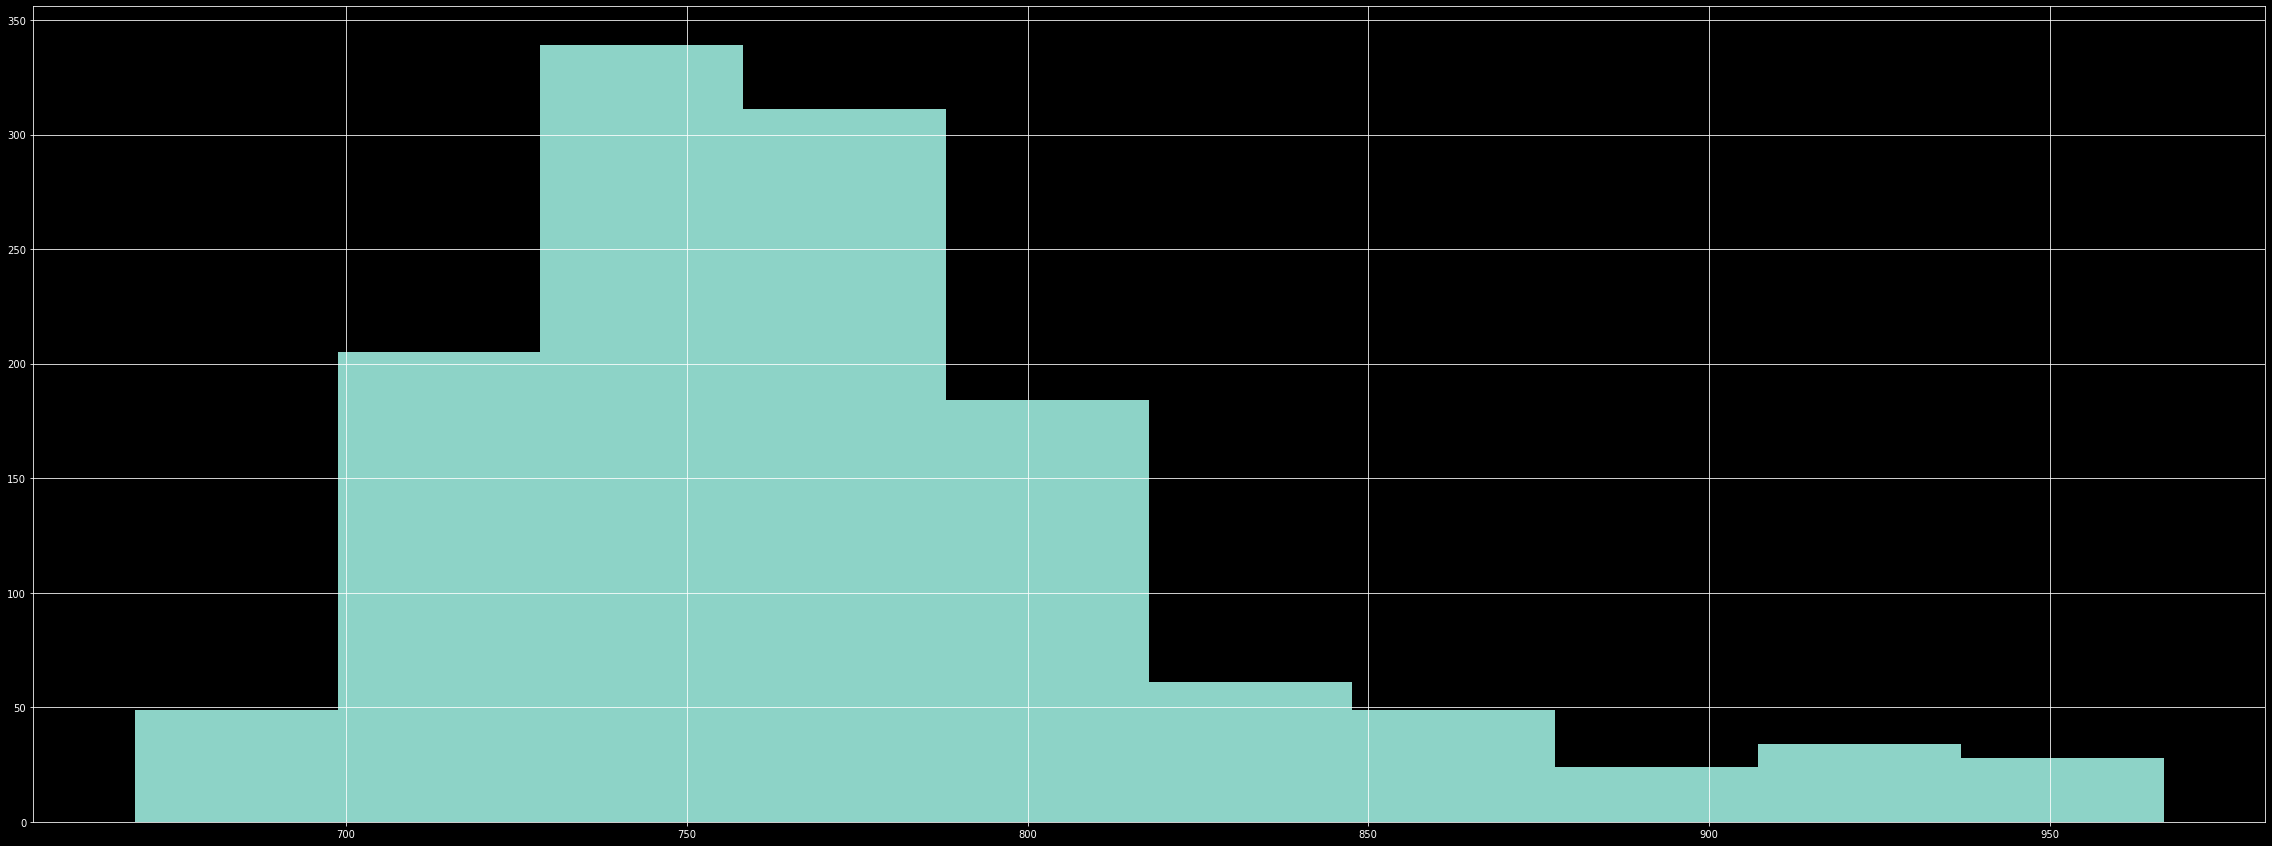

In [ ]:
results.loc['Net_Profit'].hist()

In [ ]:
plt.scatter(results.loc['Net_Profit'].index, results.loc['Net_Profit'].values)
plt.axhline(y=0)
plt.title(f"{results.loc['Net_Profit'][results.loc['Net_Profit'] > 0].size / results.loc['Net_Profit'].size * 100}% maior que 0", size=30)
plt.show()

In [ ]:
results[results.loc['Net_Profit'][results.loc['Net_Profit'] > 0].index.to_list()].loc['Annualized_Return_%'].describe()

In [ ]:
results[results.loc['Net_Profit'][results.loc['Net_Profit'] > 0].index.to_list()].loc['Max_DD_%'].describe()

In [ ]:
net_filter = results[results.loc['Net_Profit'][results.loc['Net_Profit'] > 0].index.to_list()]
net_filter

In [ ]:
annualized = net_filter[net_filter.loc['Annualized_Return_%'][net_filter.loc['Annualized_Return_%'] > 0].index.to_list()]
annualized

In [ ]:
max_dd = annualized[annualized.loc['Max_DD_%'][annualized.loc['Max_DD_%'] > -20].index.to_list()]
max_dd

In [ ]:
plt.scatter(max_dd.loc['Net_Profit'].index, max_dd.loc['Net_Profit'].values)
plt.axhline(y=0)
plt.title(f"{max_dd.loc['Net_Profit'].size / results.loc['Net_Profit'].size * 100}% dos resultados após filtro.", size=30)
plt.show()

In [ ]:
density = stats.gaussian_kde(max_dd.loc['Net_Profit'])
n, x, _ = plt.hist(max_dd.loc['Net_Profit'],histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

In [ ]:
quantile_remove = max_dd[max_dd.loc['Net_Profit'][(max_dd.loc['Net_Profit'] > max_dd.loc['Net_Profit'].quantile(0.25)) & (max_dd.loc['Net_Profit'] < max_dd.loc['Net_Profit'].quantile(0.75))].index]

In [ ]:
quantile_remove

In [ ]:
%%time
results_after_clean = pd.DataFrame()
for i in quantile_remove.columns:
  x = i.split('_')
  #robot.balance_signal3(period=int(i))
  a = robot.back_tpsl(multiply_tp=round(float(x[0]),1), multiply_sl=round(float(x[1]),1), analyse=False, multi_test=False, plot=False)
  #a = robot.back_tpsl(4.0, 0.5, analyse=False, multi_test=False, plot=False)
  results_after_clean[f'{i}'] = a['Result']

In [ ]:
%%time
results_after_clean = pd.DataFrame()
for i in quantile_remove.columns:
  x = i.split('_')
  robot.balance_signal3(sma_period=int(x[2]))
  a = robot.back_big_tpsl_ohl(multiply_tp=round(float(x[0]),1), multiply_sl=round(float(x[1]),1), analyse=False, multi_test=False, plot=False)
  #a = robot.back_big_tpsl_ohl(4.0, 0.5, analyse=False, multi_test=False, plot=False)
  results_after_clean[f'{i}'] = a['Result']

In [ ]:
results_after_clean

In [ ]:
plt.plot(results_after_clean)
plt.show()

In [ ]:
quantile_remove.loc['Annualized_Return_%'].max()

In [ ]:
quantile_remove.loc['Annualized_Return_%'][quantile_remove.loc['Annualized_Return_%'] == quantile_remove.loc['Annualized_Return_%'].max()]

In [ ]:
quantile_remove.loc['Net_Profit'].max()

In [ ]:
quantile_remove.loc['Net_Profit'][quantile_remove.loc['Net_Profit'] == quantile_remove.loc['Net_Profit'].max()]

In [ ]:
wfa_test = quantile_remove.loc['Net_Profit'][quantile_remove.loc['Net_Profit'] == quantile_remove.loc['Net_Profit'].max()].index[0].split('_')

In [ ]:
wfa_test = [round(float(wfa_test[0]),1), round(float(wfa_test[1]),1)]
wfa_test

In [ ]:
wfa_result = robot.back_big_tpsl_ohl(wfa_test[0], wfa_test[1], multi_test=True, plot=True)

In [ ]:
for i in robot.get_numpy_big_data():
  print(len(i[0]))
  print(len(i[1]))
  print(len(i[2]))
  print(len(i[3]))

In [ ]:
for i in robot.get_normal_walk_forward():
  print(len(i[1][0]))
  #print(len(i[1][1]))
  #print(len(i[1][2]))
  #print(len(i[1][3]))
  #print(len(i[1][4]))
  #print(len(i[1][5]))

In [ ]:
wfa_result

In [ ]:
wfa_result.mean(axis=1)

In [ ]:
robot.get_big_data_csv('/content/drive/MyDrive/My_Project/Dados/Data_M1_3_9kk_icmarkets.csv',drop=True,drop_list=['Unnamed: 0'])
robot.set_big_data(robot.get_big_data().iloc[300_000:].reset_index())
robot.set_big_data(robot.get_big_data().drop(columns=['index']))
robot.big_data_to_array()

In [ ]:
analy_true = robot.back_big_tpsl_ohl(4.0, 0.5, tpsl_mean=10, analyse=True, multi_test=False, plot=False)

In [ ]:
analy_false = robot.back_big_tpsl_ohl(4.0, 0.5, tpsl_mean=10, analyse=False, multi_test=False, plot=False)

In [ ]:
analy_true

In [ ]:
analy_false

In [ ]:
plt.plot(analy_false['Result'])
plt.show()

In [ ]:
%%time
results_pct = pd.DataFrame()
for i in np.arange(1, 25, 1):
  robot.pct_data(period=i)
  robot.balance_signal3()
  a = robot.back_big_tpsl_ohl(4.0, 0.5, analyse=False, multi_test=False, plot=False)
  results_pct[i] = a['Result'] 

In [ ]:
results_pct.plot()
plt.grid()

In [ ]:
%%time
a = robot.back_big_tpsl_ohl(multiply_tp=4, multiply_sl=0.5, analyse=False, multi_test=False, plot=False)

In [ ]:
robot.get_big_data_csv('/content/drive/MyDrive/My_Project/Dados/Data_M1_3_9kk_icmarkets.csv',drop=True,drop_list=['Unnamed: 0'])
robot.set_big_data(robot.get_big_data().iloc[300_000:].reset_index())
robot.set_big_data(robot.get_big_data().drop(columns=['index']))
robot.big_data_to_array()

In [ ]:
a = robot.get_big_data()

In [ ]:
a

In [ ]:
a['new_index'] = pd.Series(range(1,len(a)+1))
a.set_index('new_index', inplace=True)

In [ ]:
a

In [ ]:
a.loc[]

In [ ]:
list(range(0, 3_600_240, 240))